### Load the required packages:

In [6]:
import pandas as pd
import numpy as np
import random
import math
from scipy.integrate import odeint
import scipy.stats as stats
import matplotlib.pyplot as plt

In [8]:
# Importing the SIR data.
cases_df = pd.read_csv('data.csv',dtype=np.float64)
cases_df.columns = ['Days','Infected']

In [47]:
cases_df

,Days,Infected
0,3.0,25.0
1,4.0,75.0
2,5.0,227.0
3,6.0,296.0
4,7.0,258.0
5,8.0,236.0
6,9.0,192.0
7,10.0,126.0
8,11.0,71.0
9,12.0,28.0


In [7]:
cases = cases_df["Infected"].tolist()

In [9]:
observed_days = cases_df['Days'].tolist()

In [11]:
len(cases)

12

### Running the ABC Algorithm Implementation:

In [85]:
# Setting up the parameters of the model.
# Defining a uniform prior for the recovery parameter alpha between alpha1 and alpha2.
#This allows us to sample different values of alpha during the ABC process.

alpha1 = 0      # Lower bound for the recovery rate (alpha)
alpha2 = 1      # Upper bound for the recovery rate (alpha)

# We also define a prior for the transmission parameter beta, 
# We assumed it to be uniformly distributed between beta1 and beta2.

beta1 = 0       # Lower bound for the infection rate (beta)
beta2 = 1       # Upper bound for the infection rate (beta)

# M is the number of accepted (beta, alpha) parameter pairs we want to collect
# to approximate the posterior distributions of beta and alpha.

M = 1000        # Number of accepted samples to keep

# Initial conditions of the SIR model:
# 99,999 susceptible individuals
# 1 infected individual
# 0 recovered individuals

x0 = [738, 25, 0]  # Initial state: [S, I, R]
PopSize = sum(x0)   # Total population size

# The tolerance level for ABC rejection.
# Only simulations whose output is within this distance from the observed data 
# will be accepted. A smaller tolerance gives a better approximation but may
# require more time to accept M samples.

tolerance = 20    # Tolerance for accepting a simulated outcome


In [87]:
# We make empty lists to store:
# Accepted infection rates (beta)
# Accepted recovery rates (alpha)
# The distances between the simulated and observed data
beta_accepted = []
alpha_accepted = []
dist_accepted = []

# We now apply the ABC rejection algorithm.
# Initialize the counter for the number of accepted parameter sets.
num_accepted = 0

# Keeping track of how many total iterations we have made,
# which will help us in calculating the acceptance rate.
total_iterations = 0

# Will continue sampling parameters until we have M accepted samples.
while(num_accepted < M):
    
    # Increment the total number of trials.
    total_iterations += 1

    # Randomly draw beta (infection rate) from its prior (uniform between beta1 and beta2)
    beta = np.random.uniform(beta1, beta2, 1).item()
    
    # Randomly draw alpha (recovery rate) from its prior (uniform between alpha1 and alpha2)
    alpha = np.random.uniform(alpha1, alpha2, 1).item()
    
    # Defining the SIR ODE system using the sampled beta and alpha values.
    def dN_dt(N, t):
        S, I, R = N
        dS = -(beta) * S * I
        dI = (beta) * S * I - alpha * I
        dR = alpha * I
        return [dS, dI, dR]
    
    # The time grid for the simulation 
    ts = np.linspace(3, 14, 12)

    # Initial state: 738 susceptible, 25 infected, 0 recovered
    N0 = [738, 25, 0]
    
    # Solve the ODE system with the initial conditions over time ts
    Ns = odeint(dN_dt, N0, ts)
    
    # Extracting the simulated trajectories of S, I, and R
    susceptibles = Ns[:, 0]
    infected = Ns[:, 1]
    removed = Ns[:, 2]
    
    # Calculating the total difference between simulated infected counts
    # and the observed data.
    # Using absolute differences and then computing the Euclidean norm.
    diff = 0
    for i in range(len(infected)):
        diff += abs(infected[i] - cases[i])
    
    dist = math.sqrt(diff)  # Euclidean distance

    # Accept the sampled beta and alpha if the distance is less than the tolerance.
    if dist < tolerance:
        beta_accepted.append(beta)
        alpha_accepted.append(alpha)
        dist_accepted.append(dist)
        num_accepted += 1

        # Print progress every 100 accepted samples
        if num_accepted % 100 == 0:
            print(f"Iteration {total_iterations}: Number of accepted parameters = {num_accepted}")

# After the loop ends, compute and report the acceptance rate
acceptance_rate = num_accepted / total_iterations if total_iterations > 0 else 0
acceptance_rate *= 100

print(f"Total iterations: {total_iterations}")
print(f"Total accepted: {num_accepted}")
print(f"Acceptance rate (%): {acceptance_rate:.4f} ({num_accepted}/{total_iterations})")


Iteration 441265: Number of accepted parameters = 100
Iteration 926493: Number of accepted parameters = 200
Iteration 1450708: Number of accepted parameters = 300
Iteration 1869373: Number of accepted parameters = 400
Iteration 2335003: Number of accepted parameters = 500
Iteration 2755618: Number of accepted parameters = 600
Iteration 3270191: Number of accepted parameters = 700
Iteration 3800933: Number of accepted parameters = 800
Iteration 4280731: Number of accepted parameters = 900
Iteration 4789729: Number of accepted parameters = 1000
Total iterations: 4789729
Total accepted: 1000
Acceptance rate (%): 0.0209 (1000/4789729)


### Loading Beta and Alpha Arrays:

In [104]:
beta_accepted = np.array(beta_accepted)
alpha_accepted = np.array(alpha_accepted)
np.save("accepted_beta_eps20.npy", beta_accepted)
np.save("accepted_alpha_eps20.npy", alpha_accepted)


In [17]:

def summary_stats(parameter_array, confidence=0.95):
    mean_ = np.mean(parameter_array)
    median_ = np.median(parameter_array)
    n = len(parameter_array)
    sem = stats.sem(parameter_array)  
    h = sem * stats.t.ppf((1 + confidence) / 2., n-1)  
    
    ci = (mean_ - h, mean_ + h)
    
    return mean_, median_, ci


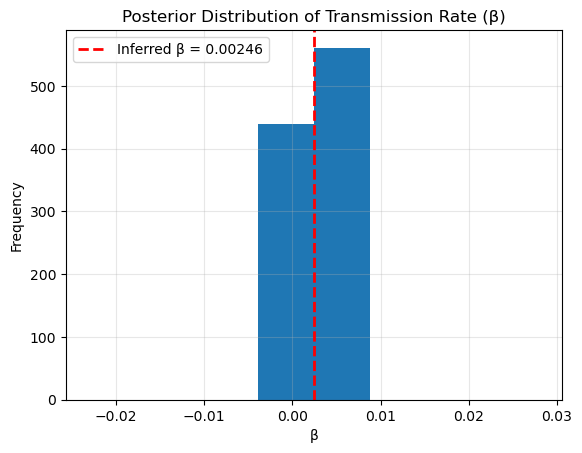

In [93]:
# Convert the list of accepted beta values to a NumPy array
beta_dist = np.array(beta_accepted)

# Create a histogram of the beta distribution with 8 bins
plt.hist(beta_dist, 8, range=(beta_dist.min() - 0.025, beta_dist.max() + 0.025))

# Add vertical line for inferred beta value
plt.axvline(x=0.00246, color='r', linestyle='--', linewidth=2, label='Inferred β = 0.00246')

# Add labels and title
plt.title('Posterior Distribution of Transmission Rate (β)')
plt.xlabel("β")
plt.ylabel("Frequency")

# Add legend and grid
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

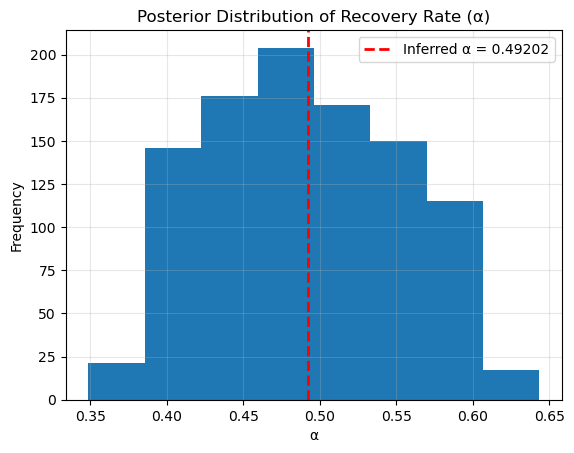

In [95]:
# Convert the list of accepted alpha values to a NumPy array
alpha_dist = np.array(alpha_accepted)

# Create histogram with 8 bins
plt.hist(alpha_dist, 8, range=(alpha_dist.min() - 0.025, alpha_dist.max() + 0.025))

# Add vertical line for inferred alpha value
plt.axvline(x=0.49202, color='r', linestyle='--', linewidth=2, label='Inferred α = 0.49202')

# Add labels and title
plt.title('Posterior Distribution of Recovery Rate (α)')
plt.xlabel("α")
plt.ylabel("Frequency")

# Add legend and grid
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

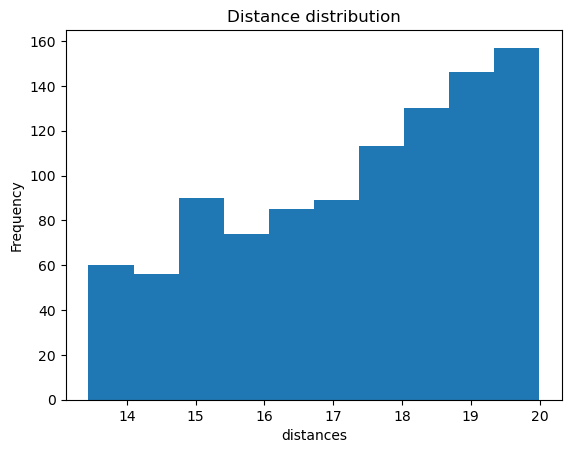

In [96]:
# Plot the distribution of accepted distances using 10 bins
fig = plt.hist(dist_accepted, 10)

# Add a title to the plot
plt.title('Distance distribution')

# Label the x-axis
plt.xlabel("distances")

# Label the y-axis
plt.ylabel("Frequency")

# Display the plot
plt.show()


### Comparison between Simple Inference and ABC Rejection Algorithm :

Point estimates — alpha: 0.4903, beta: 0.0025


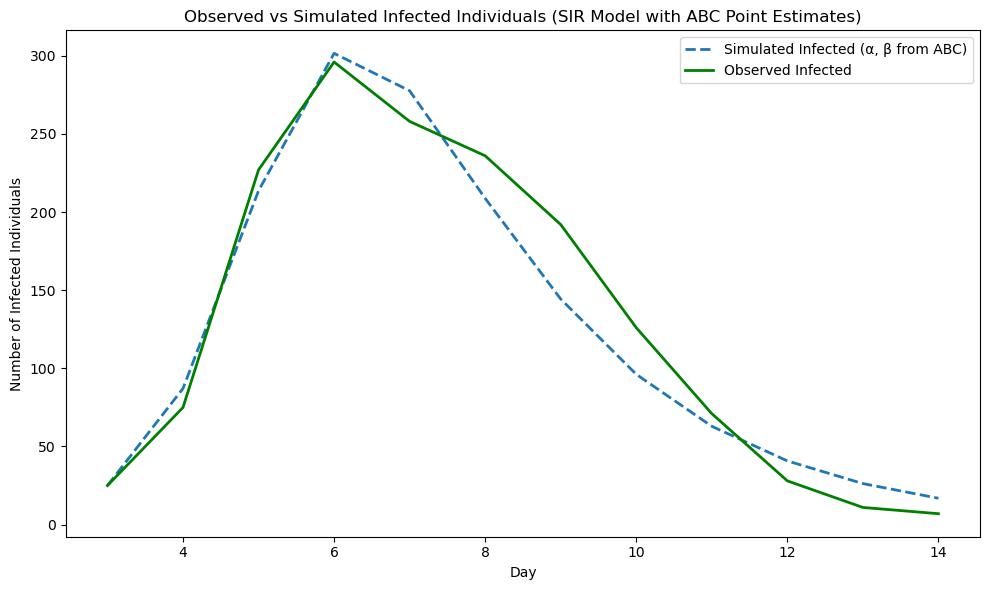

<Figure size 640x480 with 0 Axes>

In [17]:
# 1. Observed data
cases = np.array([25, 75, 227, 296, 258, 236, 192, 126, 71, 28, 11, 7])
days = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

# 2. Compute point estimates
alpha_hat = np.mean(alpha_accepted)
beta_hat = np.mean(beta_accepted)

print(f"Point estimates — alpha: {alpha_hat:.4f}, beta: {beta_hat:.4f}")

# 3. Define SIR model using point estimates
def dN_dt(N, t):
    S, I, R = N
    dS = -beta_hat * S * I
    dI = beta_hat * S * I - alpha_hat * I
    dR = alpha_hat * I
    return [dS, dI, dR]

# 4. Initial condition
N0 = [738, 25, 0]  # S, I, R

# 5. Time grid (same as in ABC)
ts = np.linspace(3, 14, 12)

# 6. Solve the SIR model
Ns = odeint(dN_dt, N0, ts)
S_sim, I_sim, R_sim = Ns.T

# 7. Plot observed vs simulated infections
plt.figure(figsize=(10,6))
# Simulated infected — dashed line
plt.plot(ts, I_sim, label='Simulated Infected (α, β from ABC)', linestyle='--', linewidth=2)

# Observed infected — solid line
plt.plot(days, cases, label='Observed Infected', color='green', linestyle='-', linewidth=2)

plt.xlabel('Day')
plt.ylabel('Number of Infected Individuals')
plt.title('Observed vs Simulated Infected Individuals (SIR Model with ABC Point Estimates)')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("./observed_vs_simulated_plot.png")

____

### Summary Statistics for $\alpha$ and $\beta$ :

###  $\beta$ :

In [13]:
## load save params
beta_array = np.load("accepted_beta.npy")
alpha_array = np.load("accepted_alpha.npy")

In [19]:
beta_summary = summary_stats(beta_array)

In [21]:
print(f"Mean of Beta params {round(beta_summary[0],5)}\nMedian of Beta params : {round(beta_summary[1], 5)}\nCI : {beta_summary[2]}")
print()
print(f"β : {round(beta_summary[0], 5)}")

Mean of Beta params 0.00248
Median of Beta params : 0.00249
CI : (0.002458466167818208, 0.0024924200322579246)

β : 0.00248


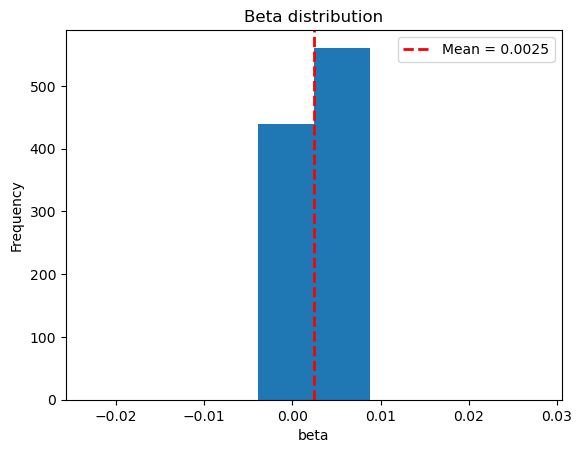

In [23]:
# Convert the list of accepted beta values to a NumPy array
# beta_dist = np.array(beta_accepted)
beta_mean = np.mean(beta_array)

# Create a histogram of the beta distribution with 8 bins, using a slightly expanded range
plt.hist(beta_array, 8, range=(beta_array.min() - 0.025, beta_array.max() + 0.025))
plt.axvline(beta_mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {beta_mean:.4f}')

# Add a title to the plot
plt.title('Beta distribution')

# Label the x-axis
plt.xlabel("beta")

# Label the y-axis
plt.ylabel("Frequency")

plt.legend()

# Display the plot
plt.show()


### $\alpha$ :

In [25]:
alpha_summary = summary_stats(alpha_array)

In [27]:
print(f"Mean of Alpha params {round(alpha_summary[0],5)}\nMedian of Alpha params : {round(alpha_summary[1], 5)}\nCI : {alpha_summary[2]}")
print()
print(f"α : {round(alpha_summary[0], 5)}")

Mean of Alpha params 0.49032
Median of Alpha params : 0.48626
CI : (0.4864622458998944, 0.4941746379614492)

α : 0.49032


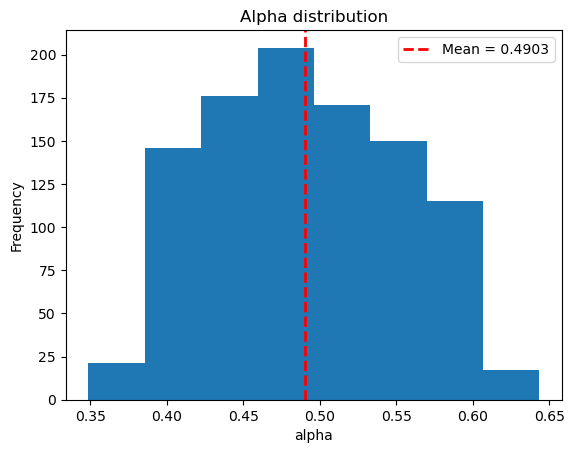

In [29]:
# Convert the list of accepted beta values to a NumPy array
# beta_dist = np.array(beta_accepted)
alpha_mean = np.mean(alpha_array)

# Create a histogram of the beta distribution with 8 bins, using a slightly expanded range
plt.hist(alpha_array, 8, range=(alpha_array.min() - 0.025, alpha_array.max() + 0.025))
plt.axvline(alpha_mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {alpha_mean:.4f}')

# Add a title to the plot
plt.title('Alpha distribution')

# Label the x-axis
plt.xlabel("alpha")

# Label the y-axis
plt.ylabel("Frequency")

plt.legend()

# Display the plot
plt.show()


### Generating $R_0$ and $I_{max}$:

In [31]:
import math

# Given parameters
beta =  0.00246
alpha = 0.49202
S_0 = 738
I_0 = 25

# Calculate R_0
R_0 = (beta / alpha) * S_0

# Calculate I_max
alpha_beta_ratio = alpha / beta
ln_alpha_beta = math.log(alpha_beta_ratio)
ln_S0 = math.log(S_0)

I_max = -alpha_beta_ratio + alpha_beta_ratio * ln_alpha_beta + S_0 + I_0 - alpha_beta_ratio * ln_S0

# Output results
print(f"R₀ = {R_0:.4f}")
print(f"I_max = {I_max:.4f}")


R₀ = 3.6899
I_max = 301.8641
